# Analysis
Here we show how the figures (similar to those) in https://doi.org/10.3390/biomimetics9060355 are generated from pre-optimized hyperparameters. This notebook assumes memory capacity data has already been computed (data included in repository). To recompute memory capacity for any hyperparameter optimization files, run compute_mc.py "*evolution_results_path*" "*destination path*". To recompute the MC for the comparison between optimized DDNs and equivalent ESNs, run removed_delays_mc.py "*ddn_evolution_results_path*" "*destination folder*". To recompute the MC for the comparison between optimized ESNs and equivalent DDNs with random delays added, run random_delays_mc.py "*esn_evolution_results_path*" "*destination folder*"

In [14]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
import pandas as pd

# Import data from hyperparameter optimization runs
MG_imports = {
    'ESN':{
        'path':"ADDN_further_experiments/Results N300 K5/2023-08-24_delay_False_bcm_False_growing_False.p"
    },    
    'DDN':{
        'path': "ADDN_further_experiments/Results N300 K5/2023-08-24_delay_True_bcm_False_growing_False.p"
    },
    'ADDN':{
        'path': "ADDN_further_experiments/Results N300 K5/2023-08-24_delay_True_bcm_True_growing_False.p"
    }
}

NARMA_10_imports = {
    'ESN':{
        'path': "NARMA-10_results_23/NARMA10_old_bl_results_n51_k4_date_2024-03-18.p"
    },    
    'DDN':{
        'path': "NARMA-10_results_23/NARMA10_old_ddn_results_n51_k4_date_2023-12-09.p"
    }
}

NARMA_30_imports = {
    'ESN':{
        'path': "NARMA-30_results_23/NARMA30_old_ddn_results_n101_k4_date_2023-12-11.p"
    },    
    'DDN':{
        'path': "NARMA-30_results_23/NARMA30_old_bl_results_n101_k4_date_2024-03-18.p"
    }
}

for key in MG_imports:
    with open(MG_imports[key]['path'], 'rb') as f:
        MG_imports[key]['results_dict'] = pkl.load(f)

for key in NARMA_10_imports:
    with open(NARMA_10_imports[key]['path'], 'rb') as f:
        NARMA_10_imports[key]['results_dict'] = pkl.load(f)
    with open(NARMA_30_imports[key]['path'], 'rb') as f:
        NARMA_30_imports[key]['results_dict'] = pkl.load(f)

narma_alphas = [1e-8, 1e-6, 1e-4, 1e-2, 1]  # Ridge regression regularisation parameters for NARMA experiments

## Overview of evolution
First, let's have a look at the validation score throughout hyperparameter evolution
### NARMA tasks
Below, the NARMA 10 and NARMA 30 validation score for DDNs and ESNs are plotted throughout CMA-ES hyperparameter evolution, similar to Figure 2.B in paper.

In [4]:
def NARMA_plot_df_from_evo_dict(dict):
    val_score_mat = dict['validation performance']
    best_scores = []
    for pop in val_score_mat:
        ind_score = []
        for ind in pop:
            best_lag_score = []
            for rep in ind:
                best_lag_score.append(np.min(rep))
            ind_score.append(best_lag_score)
        best_scores.append(ind_score)
    best_scores = np.array(best_scores)
    best_i = np.argmin(np.average(best_scores, axis=-1), axis=-1)
    plot_data_dict = {
        'Generation':[],
        'NRMSE':[]
    }
    for g, i in enumerate(best_i):
        pop = best_scores[g, i, :]
        plot_data_dict['Generation'] += list(np.repeat(g, pop.shape))
        plot_data_dict['NRMSE'] += list(pop)

    plot_df = pd.DataFrame.from_dict(plot_data_dict)
    return plot_df

In [5]:
for key in NARMA_10_imports:
    # N10
    dict = NARMA_10_imports[key]['results_dict']
    plot_df = NARMA_plot_df_from_evo_dict(dict)
    NARMA_10_imports[key]['evo_df'] = plot_df
    # N30
    dict = NARMA_30_imports[key]['results_dict']
    plot_df = NARMA_plot_df_from_evo_dict(dict)
    NARMA_30_imports[key]['evo_df'] = plot_df

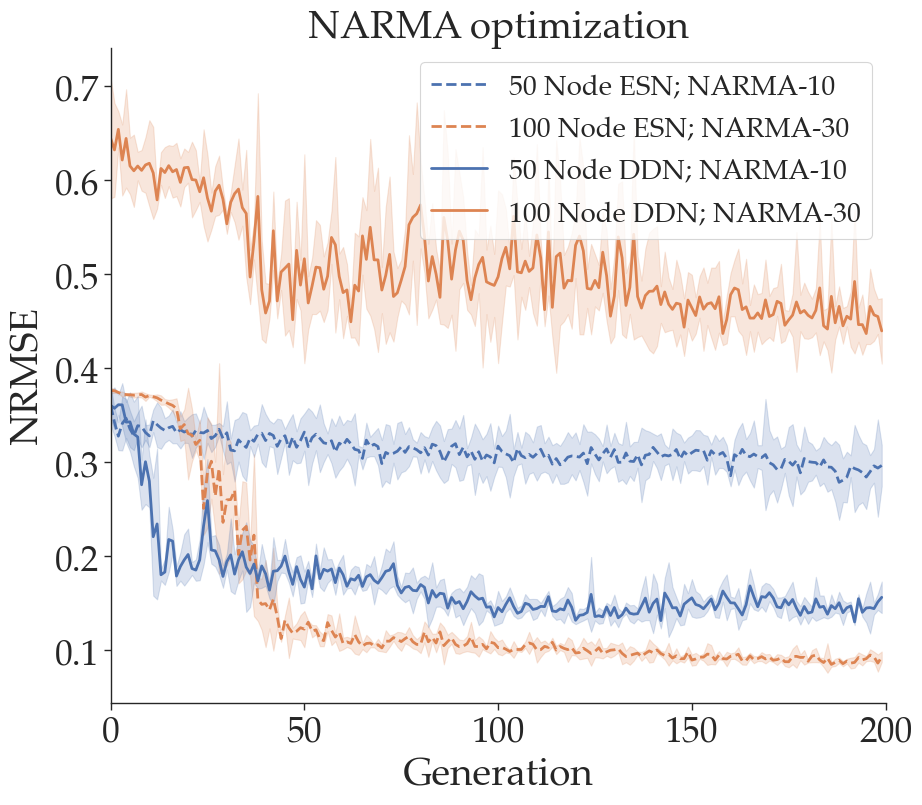

In [6]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font='Palatino Linotype', font_scale=2.9, palette='deep', context='paper', rc=custom_params)

fig, ax= plt.subplots(figsize=(10,8.5))

sns.lineplot(NARMA_10_imports['ESN']['evo_df'], x='Generation', y='NRMSE', ax=ax, linewidth=2, color='C0', linestyle="--", label="50 Node ESN; NARMA-10", errorbar='sd')
sns.lineplot(NARMA_30_imports['ESN']['evo_df'], x='Generation', y='NRMSE', ax=ax, linewidth=2, color='C1', linestyle="--", label="100 Node ESN; NARMA-30", errorbar='sd')

sns.lineplot(NARMA_10_imports['DDN']['evo_df'], x='Generation', y='NRMSE', ax=ax, linewidth=2, color='C0', linestyle="-", label="50 Node DDN; NARMA-10", errorbar='sd')
sns.lineplot(NARMA_30_imports['DDN']['evo_df'], x='Generation', y='NRMSE', ax=ax, linewidth=2, color='C1', linestyle="-", label="100 Node DDN; NARMA-30", errorbar='sd')

plt.xlim(0,200)
plt.xlabel('Generation')
plt.ylabel('NRMSE')
plt.title("NARMA optimization")
ax.legend(fontsize=20)

### Mackey Glass task
Below, the mackey-glass validation score for DDNs are plotted throughout CMA-ES hyperparameter evolution, similar to Figure 2.A in paper.

In [7]:
def MG_plot_df_from_evo_dict(dict):
    df_dict = {
        'Generation' : [],
        'Prediction Horizon' : []
    }
    best_i = np.argmax(np.mean(dict['validation performance'], axis=-1),axis=-1)
    plot = []
    for ind, i in enumerate(best_i):
        plot.append(dict['validation performance'][ind, i, :])
    plot = np.array(plot)

    for gen, pop in enumerate(plot):
        df_dict['Generation'] += list(np.repeat(gen, pop.shape))
        df_dict['Prediction Horizon'] += list(pop)
    df_plot = pd.DataFrame.from_dict(df_dict)
    return df_plot

In [8]:
for key in MG_imports:
    dict = MG_imports[key]['results_dict']
    plot_df = MG_plot_df_from_evo_dict(dict)
    MG_imports[key]['evo_df'] = plot_df

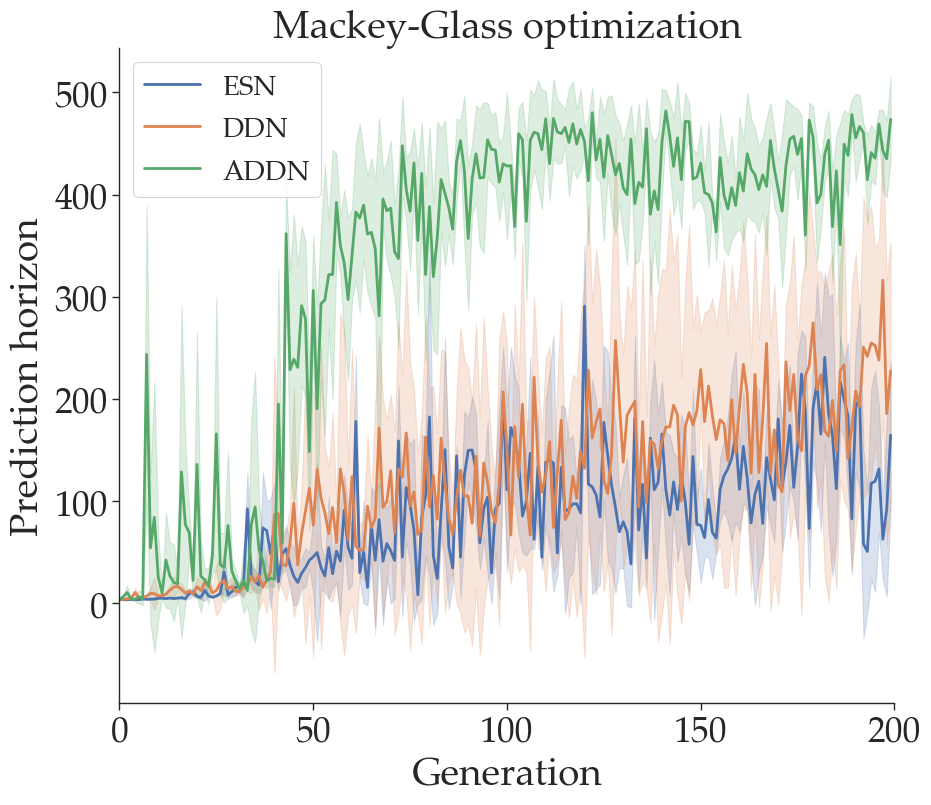

In [9]:
fig, ax= plt.subplots(figsize=(10,8.5))
sns.lineplot(MG_imports['ESN']['evo_df'], x='Generation', y='Prediction Horizon', ax=ax, linewidth=2, linestyle="-",label="ESN", errorbar='sd')
sns.lineplot(MG_imports['DDN']['evo_df'], x='Generation', y='Prediction Horizon', ax=ax, linewidth=2, linestyle="-",label="DDN", errorbar='sd')
sns.lineplot(MG_imports['ADDN']['evo_df'], x='Generation', y='Prediction Horizon', ax=ax, linewidth=2, linestyle="-",label="ADDN", errorbar='sd')
# sns.lineplot(DDN_plot, ax=ax, linewidth=2, linestyle="-", label="DDN")
# sns.lineplot(ADDN_plot, ax=ax, linewidth=2, linestyle="-", label="ADDN")
plt.xlim(0,200)
plt.xlabel('Generation')
plt.ylabel('Prediction horizon')
plt.title('Mackey-Glass optimization')
ax.legend(fontsize=20)

## MC: Evolved DDN vs equivalent ESN
The simplest way to compare linear MC between DDNs and ESNs is to take an optimzed DDN and remove the delays (figure 3. in the paper).

In [10]:
filename = "mc_random_delays/evolved_DDN.p"
with open(filename, 'rb') as file:
    m_caps_evolved_net = pkl.load(file)
m_caps_evolved_net = m_caps_evolved_net[:, :60]**2
filename = "mc_random_delays/evolved_DDN_removed_delays.p"
with open(filename, 'rb') as file:
    m_caps_removed_delays = pkl.load(file)
m_caps_removed_delays = m_caps_removed_delays[:, :60]**2

steps = np.arange(m_caps_evolved_net.shape[1])
df = pd.DataFrame(m_caps_evolved_net.T, index=steps).reset_index()
df_long = df.melt(id_vars="index", var_name="sequence", value_name="MC")
df_long.rename(columns={"index": "Lag"}, inplace=True)
df_long['type'] = 'Evolved Network'
df_2 = pd.DataFrame(m_caps_removed_delays.T, index=steps).reset_index()
df_long_2 = df_2.melt(id_vars="index", var_name="sequence", value_name="MC")
df_long_2.rename(columns={"index": "Lag"}, inplace=True)
df_long_2['type'] = 'Delays Removed'
df_long = pd.concat([df_long, df_long_2], ignore_index=True)
print(df_long.head())

   Lag sequence        MC             type
0    0        0  0.000033  Evolved Network
1    1        0  0.000003  Evolved Network
2    2        0  0.000537  Evolved Network
3    3        0  0.000195  Evolved Network
4    4        0  0.000606  Evolved Network


Text(0.5, 1.0, 'MC: DDNs vs no delay')

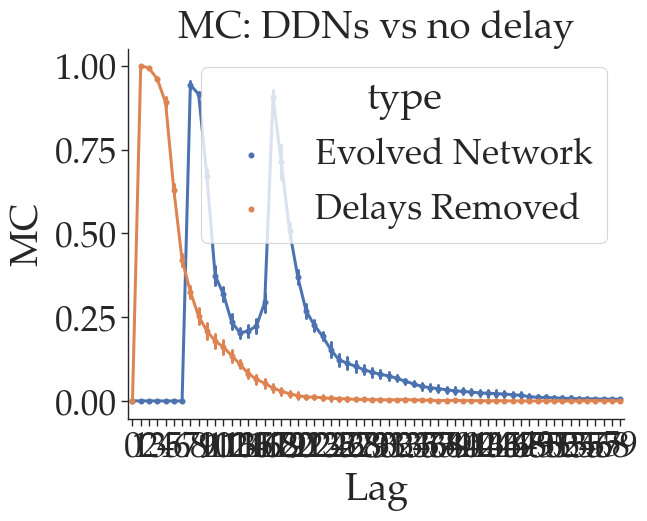

In [11]:
sns.pointplot(df_long, x="Lag", y="MC", hue='type', errorbar='sd', markers='.')
plt.title('MC: DDNs vs no delay')


## Random Network MC
Here we compare random unevolved network memory capacity in delayed networks (DDNs) and conventional RNNs, with delays added randomly, with increasing magnitude

In [12]:
# Import MC
filename = "mc_random_delays/evolved_BL_delays_added_far_input.p"
with open(filename, 'rb') as file:
    mc_added_delays_far = pkl.load(file)

filename = "mc_random_delays/evolved_BL_delays_added.p"
with open(filename, 'rb') as file:
    mc_added_delays_near = pkl.load(file)
mc_added_delays_near[0] = mc_added_delays_far[0]

### Random network far input
Below the Figure 4C form the paper is generated: random networks with increasing size and a distal input neuron.

(150,)
(150,)
(150,)
(150,)
(150,)


Text(0, 0.5, '$r^2$(input, reproduced input)')

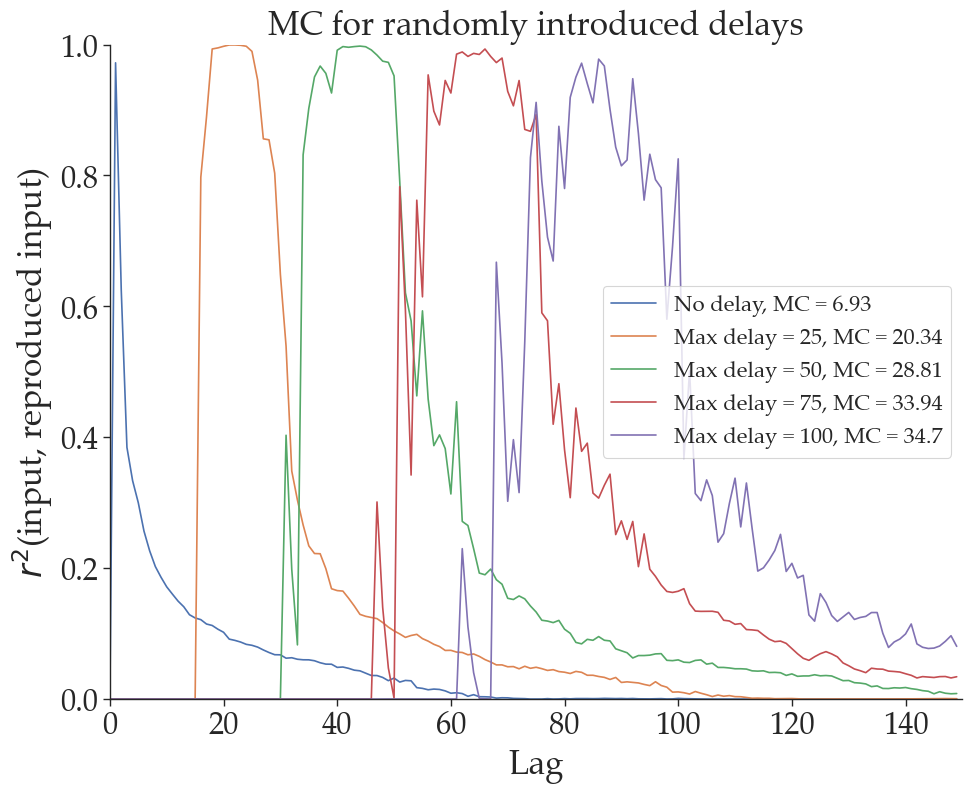

In [13]:
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font='Palatino Linotype', font_scale=2.5, palette='deep', context='paper', rc=custom_params)
plt.figure(figsize=(11,8.5))
total_mc = []

for mc in mc_added_delays_far:
    mc = np.array(mc)**2
    print(mc.shape)
    plt.plot(mc)
    total_mc.append(round(np.sum(mc), 2))

plt.title("MC for randomly introduced delays")
plt.ylim(0, 1)
plt.xlim(0, 150)
plt.legend([
    'No delay, MC = ' + str(total_mc[0]),
    'Max delay = 25, MC = ' + str(total_mc[1]),
    'Max delay = 50, MC = ' + str(total_mc[2]),
    'Max delay = 75, MC = ' + str(total_mc[3]),
    'Max delay = 100, MC = ' + str(total_mc[4]),
], fontsize = 16)
plt.xlabel("Lag")
plt.ylabel(r"$r^2$(input, reproduced input)")

### Random network near input
Below Figure 4A form the paper is generated: random networks with increasing size and an input neuron close to the reservoir.

Text(0, 0.5, '$r^2$(input, reproduced input)')

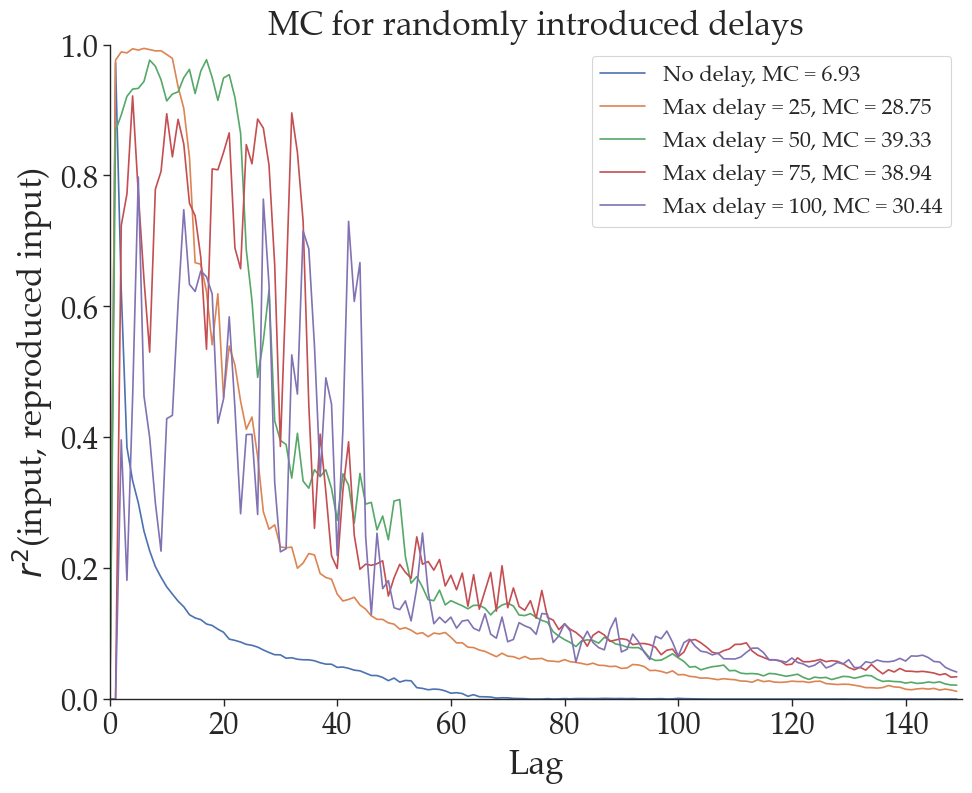

In [14]:
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font='Palatino Linotype', font_scale=2.5, palette='deep', context='paper', rc=custom_params)
plt.figure(figsize=(11,8.5))
total_mc = []

for mc in mc_added_delays_near:
    mc = np.array(mc)**2
    plt.plot(mc)
    total_mc.append(round(np.sum(mc), 2))

plt.title("MC for randomly introduced delays")
plt.ylim(0, 1)
plt.xlim(0, 150)
plt.legend([
    'No delay, MC = ' + str(total_mc[0]),
    'Max delay = 25, MC = ' + str(total_mc[1]),
    'Max delay = 50, MC = ' + str(total_mc[2]),
    'Max delay = 75, MC = ' + str(total_mc[3]),
    'Max delay = 100, MC = ' + str(total_mc[4]),
], fontsize = 16)
plt.xlabel("Lag")
plt.ylabel(r"$r^2$(input, reproduced input)")

## Linear Memory Capacity of optimized networks throughout evolution: NARMA
In the following cells, the panels of Figure 5 in the paper are generated. We look at MC measured at every 10th generation throughout the CMA-ES hyperparameter optimization, comparing ESNs with DDNs in NARMA 10 and 30 tasks.

### Load MC data
Pre-computed MC data is included. To re-generate new MC data, run compute_mc.py "*evolution_results_path*" "*destination path*". This will take a while

In [15]:
def lag_comp(mc_dict):
    # Input delay requires compensation in readout layer (lagged readout layer).
    # this must then again be compensated when analysing MC
    evo_dict = mc_dict['evolution results']
    m_caps_evo = mc_dict['memory capacities']
    best_lag_scores = np.argmin(evo_dict['validation performance'], axis=-1)
    scores = np.mean(np.min(evo_dict['validation performance'], axis=-1), axis=-1)
    max_gen = best_lag_scores.shape[0]
    best_lags_evo = []
    for gen in np.arange(0, max_gen, 10):
        i = np.argmin(scores[gen])
        best_lags = best_lag_scores[gen, i]
        best_lags_evo.append(best_lags)

    m_cap_lag_compensated = []
    margin = 15
    for i, mcaps in enumerate(m_caps_evo):
        comp_mcaps = []
        for j, mcap in enumerate(mcaps):
            lag = best_lags_evo[i][j]
            comp_mcap = mcap[lag:-margin + lag]
            comp_mcaps.append(comp_mcap)
        m_cap_lag_compensated.append(comp_mcaps)

    m_cap_lag_compensated = np.array(m_cap_lag_compensated)
    return m_cap_lag_compensated

In [16]:
NARMA_10_imports['ESN']['mc_path'] = "saved_m_caps_evo/MC_throughout_evolution_bl_NARMA10_N50.p"
NARMA_10_imports['DDN']['mc_path'] = "saved_m_caps_evo/MC_throughout_evolution_ddn_NARMA10_N50.p"
NARMA_30_imports['ESN']['mc_path'] = "saved_m_caps_evo/MC_throughout_evolution_bl_NARMA30_N100.p"
NARMA_30_imports['DDN']['mc_path'] = "saved_m_caps_evo/MC_throughout_evolution_ddn_NARMA30_N100.p"

for key in NARMA_10_imports:
    with open(NARMA_10_imports[key]['mc_path'], 'rb') as file:
        mc_dict = pkl.load(file)
    m_cap_comp_evo = lag_comp(mc_dict)
    print(m_cap_comp_evo.shape)
    NARMA_10_imports[key]['mc_array'] = m_cap_comp_evo

for key in NARMA_30_imports:
    with open(NARMA_30_imports[key]['mc_path'], 'rb') as file:
        mc_dict = pkl.load(file)
    m_cap_comp_evo = lag_comp(mc_dict)
    print(m_cap_comp_evo.shape)  # Shape: Generations x nr of Network samples from "genome" x maximum lag
    NARMA_30_imports[key]['mc_array'] = m_cap_comp_evo

(20, 5, 85)
(20, 5, 85)
(20, 5, 85)
(20, 5, 85)


### Plot NARMA-10 ESN MC
Paper Figure 5.C

Text(0.5, 1.0, 'ESN linear MC throughout evolution: NARMA-10')

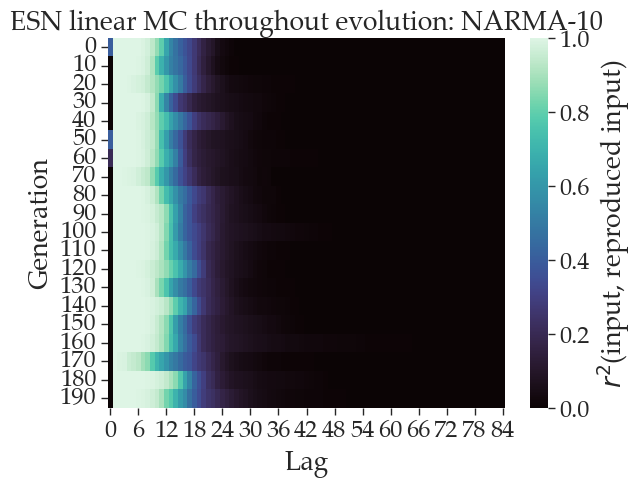

In [17]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font='Palatino Linotype', font_scale=2, palette='deep', context='paper', rc=custom_params)
gens = np.arange(0, 200, 10)
sns.heatmap(np.mean(NARMA_10_imports['ESN']['mc_array']**2, axis=1)[:, :], vmin=0, vmax=1, yticklabels=gens,
            cbar_kws={'label': r'$r^2$(input, reproduced input)'}, cmap="mako")
plt.xlabel("Lag")
plt.ylabel("Generation")
plt.title("ESN linear MC throughout evolution: NARMA-10")

### Plot NARMA-10 DDN MC
Paper Figure 5.A

Text(0.5, 1.0, 'DDN linear MC throughout evolution: NARMA-10')

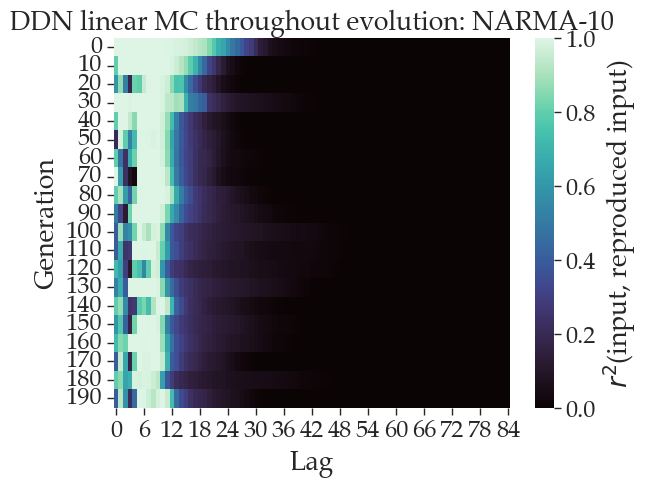

In [18]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font='Palatino Linotype', font_scale=2, palette='deep', context='paper', rc=custom_params)
gens = np.arange(0, 200, 10)
sns.heatmap(np.mean(NARMA_10_imports['DDN']['mc_array']**2, axis=1)[:, :], vmin=0, vmax=1, yticklabels=gens,
            cbar_kws={'label': r'$r^2$(input, reproduced input)'}, cmap="mako")
plt.xlabel("Lag")
plt.ylabel("Generation")
plt.title("DDN linear MC throughout evolution: NARMA-10")

### Plot NARMA-30 ESN MC
Paper Figure 5.D

Text(0.5, 1.0, 'ESN linear MC throughout evolution: NARMA-30')

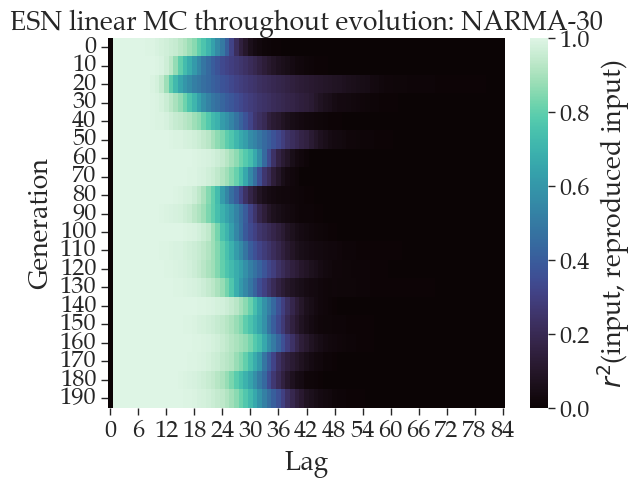

In [19]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font='Palatino Linotype', font_scale=2, palette='deep', context='paper', rc=custom_params)
gens = np.arange(0, 200, 10)
sns.heatmap(np.mean(NARMA_30_imports['ESN']['mc_array']**2, axis=1)[:, :], vmin=0, vmax=1, yticklabels=gens,
            cbar_kws={'label': r'$r^2$(input, reproduced input)'}, cmap="mako")
plt.xlabel("Lag")
plt.ylabel("Generation")
plt.title("ESN linear MC throughout evolution: NARMA-30")

### Plot NARMA-30 DDN MC
Paper Figure 5.B

Text(0.5, 1.0, 'DDN linear MC throughout evolution: NARMA-30')

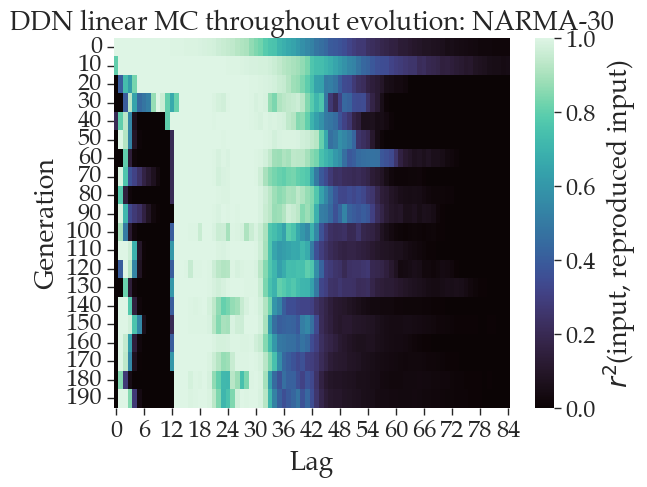

In [20]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font='Palatino Linotype', font_scale=2, palette='deep', context='paper', rc=custom_params)
gens = np.arange(0, 200, 10)
sns.heatmap(np.mean(NARMA_30_imports['DDN']['mc_array']**2, axis=1)[:, :], vmin=0, vmax=1, yticklabels=gens,
            cbar_kws={'label': r'$r^2$(input, reproduced input)'}, cmap="mako")
plt.xlabel("Lag")
plt.ylabel("Generation")
plt.title("DDN linear MC throughout evolution: NARMA-30")

## Linear Memory Capacity of optimized networks throughout evolution: Mackey-Glass
In the following cells, the panels of Figure 6 in the paper are generated. We look at MC measured at every 10th generation throughout the CMA-ES hyperparameter optimization, comparing ESNs, DDNs and ADDNs in Mackey-Glass tasks.

### Load MC data
Pre-computed MC data is included. To re-generate new MC data, run compute_mc.py "*evolution_results_path*" "*destination path*". This will take a while

In [49]:
MG_imports['ESN']['mc_path'] = "saved_m_caps_evo/MC_throughout_evolution_bl_MG.p"
MG_imports['DDN']['mc_path'] = "saved_m_caps_evo/MC_throughout_evolution_ddn.p"
MG_imports['ADDN']['mc_path'] = "saved_m_caps_evo/MC_throughout_evolution_addn.p"

max_lag = 45  # Maximum MC lag to be plotted

for key in MG_imports:
    with open(MG_imports[key]['mc_path'], 'rb') as file:
        mc_dict = pkl.load(file)
    m_cap_evo_MG = np.array(mc_dict['memory capacities'])
    print(m_cap_evo_MG.shape)  # Shape: Generations x nr of Network samples from "genome" x maximum lag
    MG_imports[key]['mc_array'] = m_cap_evo_MG[:, :, :max_lag]

(20, 5, 100)
(20, 5, 100)
(20, 5, 100)


### Plot Mackey-Glass ESN MC
Paper Figure 6.C

Text(0.5, 1.0, 'ESN linear MC throughout evolution: Mackey-Glass')

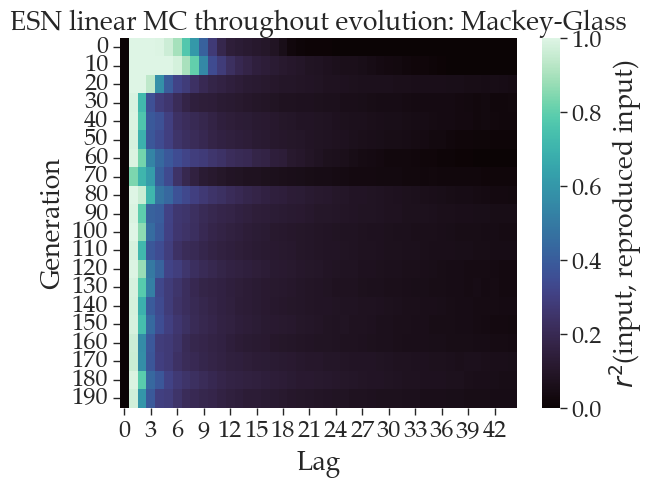

In [32]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font='Palatino Linotype', font_scale=2, palette='deep', context='paper', rc=custom_params)
gens = np.arange(0, 200, 10)
sns.heatmap(np.mean(MG_imports['ESN']['mc_array']**2, axis=1)[:, :], vmin=0, vmax=1, yticklabels=gens,
            cbar_kws={'label': r'$r^2$(input, reproduced input)'}, cmap="mako")
plt.xlabel("Lag")
plt.ylabel("Generation")
plt.title("ESN linear MC throughout evolution: Mackey-Glass")

### Plot Mackey-Glass DDN MC
Paper Figure 6.A

Text(0.5, 1.0, 'DDN linear MC throughout evolution: Mackey-Glass')

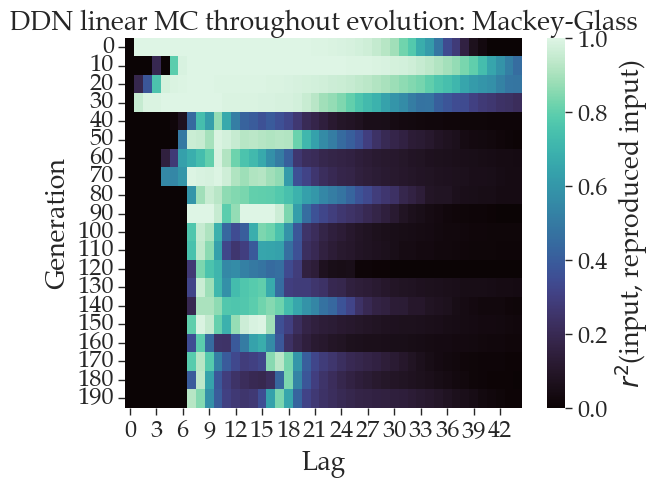

In [33]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font='Palatino Linotype', font_scale=2, palette='deep', context='paper', rc=custom_params)
gens = np.arange(0, 200, 10)
sns.heatmap(np.mean(MG_imports['DDN']['mc_array']**2, axis=1)[:, :], vmin=0, vmax=1, yticklabels=gens,
            cbar_kws={'label': r'$r^2$(input, reproduced input)'}, cmap="mako")
plt.xlabel("Lag")
plt.ylabel("Generation")
plt.title("DDN linear MC throughout evolution: Mackey-Glass")

### Plot Mackey-Glass ADDN MC
Paper Figure 6.B

Text(0.5, 1.0, 'ADDN linear MC throughout evolution: Mackey-Glass')

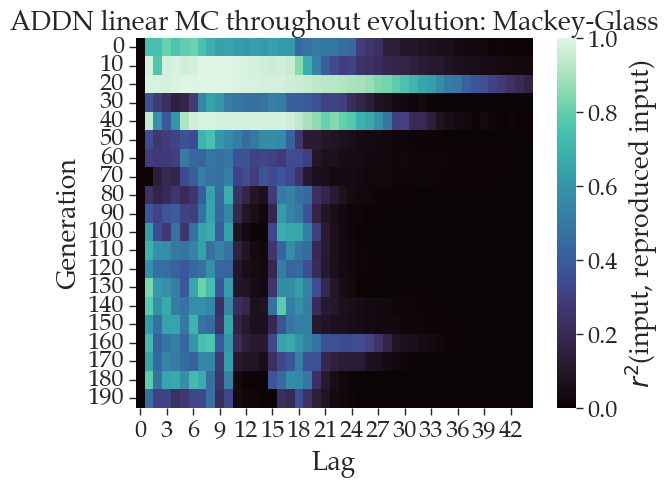

In [34]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font='Palatino Linotype', font_scale=2, palette='deep', context='paper', rc=custom_params)
gens = np.arange(0, 200, 10)
sns.heatmap(np.mean(MG_imports['ADDN']['mc_array']**2, axis=1)[:, :], vmin=0, vmax=1, yticklabels=gens,
            cbar_kws={'label': r'$r^2$(input, reproduced input)'}, cmap="mako")
plt.xlabel("Lag")
plt.ylabel("Generation")
plt.title("ADDN linear MC throughout evolution: Mackey-Glass")

## Task Profiles
Lastly, the linear memory requirements of tasks can be visualized using task profiles, which can be compared with the MC profiles of DDN and ESN models optimized to that task (see Figure 5.E, 5.F, and 6.D in the paper)


In [37]:
from utils import createNARMA10, createNARMA30
from reservoirpy.datasets import mackey_glass
# Generate task data
s = 100000
data_train30 = np.array(createNARMA30(s)).reshape((2, s))
data_train10 = np.array(createNARMA10(s)).reshape((2, s))
data_mg = mackey_glass(s)

In [45]:
# Compute task memory profile
lags_narma = 60
lags_mg = 45
margin = 200

task_corrs10 = []
task_corrs30 = []

for i in range(0, lags_narma):
    if i == 0:
        task_out_10 = data_train10[1, margin:]
        task_in_10 = data_train10[0, margin:]
        task_out_30 = data_train30[1, margin:]
        task_in_30 = data_train30[0, margin:]
    else:
        task_out_10 = data_train10[1, margin:]
        task_in_10 = data_train10[0, margin-i:-i]
        task_out_30 = data_train30[1, margin:]
        task_in_30 = data_train30[0, margin-i:-i]

    task_corrs10.append(np.corrcoef(task_out_10, task_in_10)[0, 1]**2)
    task_corrs30.append(np.corrcoef(task_out_30, task_in_30)[0, 1]**2)

mg_autocorrs = []
for i in range(0, lags_mg):
    if i == 0:
        autocorr = 1
    else:
        autocorr = np.corrcoef(data_mg[i:].T, data_mg[:-i].T)[0, 1] ** 2
    mg_autocorrs.append(autocorr)

### NARMA 10
Figure 5.E

(0.0, 1.0)

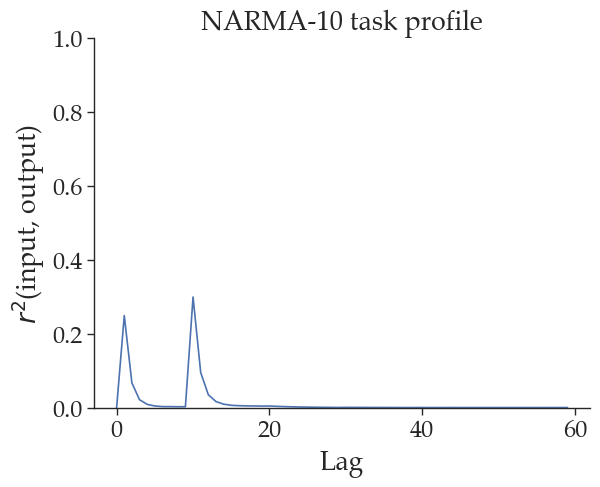

In [42]:
sns.lineplot(task_corrs10)
plt.xlabel("Lag")
plt.ylabel("$r^2$(input, output)")
plt.title("NARMA-10 task profile")
plt.ylim(0, 1)

### NARMA 30
Figure 5.F

(0.0, 1.0)

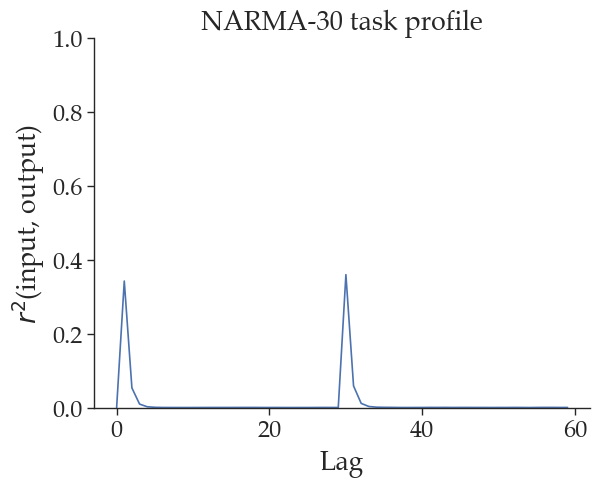

In [43]:
sns.lineplot(task_corrs30)
plt.xlabel("Lag")
plt.ylabel("$r^2$(input, output)")
plt.title("NARMA-30 task profile")
plt.ylim(0, 1)

### Mackey-Glass
Figure 6.D

(0.0, 1.0)

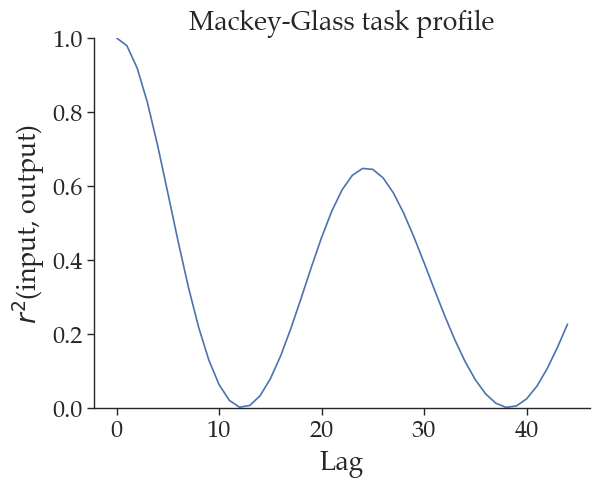

In [46]:
sns.lineplot(mg_autocorrs)
plt.xlabel("Lag")
plt.ylabel("$r^2$(input, output)")
plt.title("Mackey-Glass task profile")
plt.ylim(0, 1)